## Adapt to Google Colab

In [ ]:
!unzip /content/02_raw_train.zip

Archive:  /content/02_raw_train.zip
   creating: 02_raw_train/images/
   creating: 02_raw_train/images/0_punching_hole/
   creating: 02_raw_train/images/1_welding_line/
   creating: 02_raw_train/images/2_crescent_gap/
   creating: 02_raw_train/images/3_water_spot/
   creating: 02_raw_train/images/4_oil_spot/
   creating: 02_raw_train/images/5_silk_spot/
   creating: 02_raw_train/images/6_inclusion/
   creating: 02_raw_train/images/7_rolled_pit/
   creating: 02_raw_train/images/8_crease/
   creating: 02_raw_train/images/9_waist_folding/
  inflating: 02_raw_train/0_punching_hole.csv  
  inflating: 02_raw_train/1_welding_line.csv  
  inflating: 02_raw_train/2_crescent_gap.csv  
  inflating: 02_raw_train/3_water_spot.csv  
  inflating: 02_raw_train/4_oil_spot.csv  
  inflating: 02_raw_train/5_silk_spot.csv  
  inflating: 02_raw_train/6_inclusion.csv  
  inflating: 02_raw_train/7_rolled_pit.csv  
  inflating: 02_raw_train/8_crease.csv  
  inflating: 02_raw_train/9_waist_folding.csv  
  infl

## Dependencies

In [23]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## HPs

In [6]:
# Configuration
batch_size = 4
image_size = 64
num_workers = 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


## Dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, labels_file, root_dir, transform=None):
        self.annotations = pd.read_csv(labels_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 1]), self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[(index, 2)]))

        if self.transform:
            image = self.transform(image)

        return(image, label)
    
    def __getlabel__(self, index):
        label = (self.annotations.iloc[(index, 1)])        

        return(label)

In [ ]:
preprocessing = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0,), (1,))
                                   ])

In [ ]:
labels_file = '/content/gc10-det/02_raw_train/3_water_spot.csv'
root_dir = '/content/gc10-det/02_raw_train/images/'

dataset = Dataset(labels_file=labels_file, root_dir=root_dir, transform=preprocessing)

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
image, _ = dataset.__getitem__(1)
torch.min(image)

tensor(0.3529)

In [ ]:
print(f"Len of dataset {dataset.__len__()}")
print(f"Len of dataloader {dataloader.__len__()}")

Len of dataset 184
Len of dataloader 46


## Model Definition

In [10]:
# 4 convs - LeakyRelu

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)
        self.batch4 = nn.BatchNorm2d(256)
        self.linear1 = nn.Linear (256 * 3 * 3, 1152) #! Dimensions
        self.linear2 = nn.Linear(1152, latent_dims)
        self.linear3 = nn.Linear(1152, latent_dims)

        self.N = torch.distributions.Normal(0, 1)

        if torch.cuda.is_available():
          self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
          self.N.scale = self.N.scale.cuda()

        self.kl = 0


    def forward(self, x):

        x = x.to(device)
        x = F.leaky_relu(self.batch1(self.conv1(x)))
        x = F.leaky_relu(self.batch2(self.conv2(x)))
        x = F.leaky_relu(self.batch3(self.conv3(x)))
        x = F.leaky_relu(self.batch4(self.conv4(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)

        self.kl = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        return z      


class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1152),
            nn.LeakyReLU(),
            nn.Linear(1152, 256 * 3 * 3),
            nn.LeakyReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## Training

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(42)
d = 4
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-4 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (batch4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=2304, out_features=1152, bias=True)
    (linear2): Linear(in_features=1152, out_features=4, bias=True)
    (linear3): Linear(in_features=1152, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
  

In [28]:
encoder_view = VariationalAutoencoder(d).to(device)
summary(encoder_view, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 16, 16]          18,496
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 256, 3, 3]         295,168
       BatchNorm2d-8            [-1, 256, 3, 3]             512
            Linear-9                 [-1, 1152]       2,655,360
           Linear-10                    [-1, 4]           4,612
           Linear-11                    [-1, 4]           4,612
VariationalEncoder-12                    [-1, 4]               0
           Linear-13                 [-1, 1152]           5,760
        LeakyReLU-14                 [

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer, loss_fn):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)

        # Evaluate loss
        reconst_loss = loss_fn(x_hat, x)
        loss = reconst_loss + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track batch loss
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
num_epochs = 800
train_loss_log = []
loss_fn = nn.BCELoss(reduction="sum")

for epoch in range(num_epochs):
   train_loss = train_epoch(vae, device, dataloader, optim, loss_fn)
   train_loss_log.append(train_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))


 EPOCH 1/800 	 train loss 2736.956

 EPOCH 2/800 	 train loss 2588.132

 EPOCH 3/800 	 train loss 2547.579

 EPOCH 4/800 	 train loss 2516.432

 EPOCH 5/800 	 train loss 2496.469

 EPOCH 6/800 	 train loss 2475.913

 EPOCH 7/800 	 train loss 2472.339

 EPOCH 8/800 	 train loss 2467.584

 EPOCH 9/800 	 train loss 2460.571

 EPOCH 10/800 	 train loss 2464.224

 EPOCH 11/800 	 train loss 2462.091

 EPOCH 12/800 	 train loss 2456.138

 EPOCH 13/800 	 train loss 2450.390

 EPOCH 14/800 	 train loss 2450.386

 EPOCH 15/800 	 train loss 2454.481

 EPOCH 16/800 	 train loss 2448.057

 EPOCH 17/800 	 train loss 2454.915

 EPOCH 18/800 	 train loss 2445.341

 EPOCH 19/800 	 train loss 2445.486

 EPOCH 20/800 	 train loss 2443.917

 EPOCH 21/800 	 train loss 2445.336

 EPOCH 22/800 	 train loss 2441.693

 EPOCH 23/800 	 train loss 2442.951

 EPOCH 24/800 	 train loss 2443.341

 EPOCH 25/800 	 train loss 2444.373

 EPOCH 26/800 	 train loss 2444.344

 EPOCH 27/800 	 train loss 2442.346

 EPOCH 28

## Training Loss

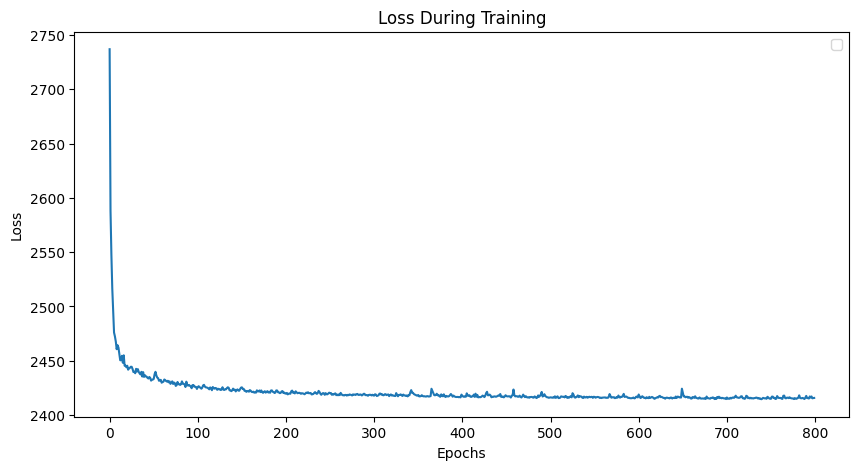

In [ ]:
# import seaborn as sns
# sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(train_loss_log)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Showing the Results

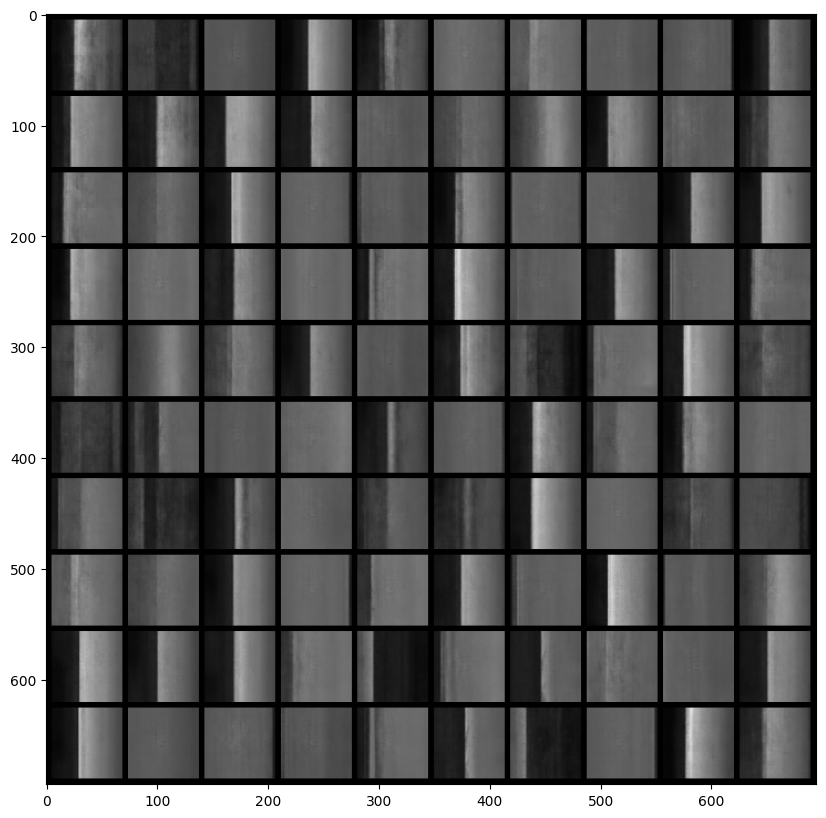

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(15, 10))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## Saving the Images

In [ ]:
def save_synthetic_data(dataset, save_path, num_instances, vae):
    num_images = num_instances - dataset.__len__()
    vae.eval()
    with torch.no_grad():
        # sample latent vectors from the normal distribution
        latent = torch.randn(num_images, d, device=device)

        # reconstruct images from the latent vectors
        img_recon = vae.decoder(latent)
        img_recon = img_recon.cpu()

        for i in range(num_images):
            tensor_image = img_recon[i].detach().cpu()
            pil_image = transforms.ToPILImage()(tensor_image)
            pil_image = transforms.Resize((224, 224))(pil_image)
            pil_image.save(os.path.join(save_path, dataset.__getlabel__(0), 'vae_'+str(dataset.__getlabel__(0))+'_'+str(i)+'.jpg'))


In [ ]:
save_path = "/content/05_vae"
num_instances = 1000

save_synthetic_data(dataset, save_path, num_instances, vae)

## Downloading

In [ ]:
!zip -r 3_water_spot.zip /content/05_vae/3_water_spot

  adding: content/05_vae/3_water_spot/ (stored 0%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_630.jpg (deflated 2%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_686.jpg (deflated 2%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_573.jpg (deflated 0%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_311.jpg (deflated 1%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_464.jpg (deflated 4%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_123.jpg (deflated 5%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_135.jpg (deflated 2%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_246.jpg (deflated 0%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_212.jpg (deflated 1%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_694.jpg (deflated 1%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_102.jpg (deflated 1%)
  adding: content/05_vae/3_water_spot/vae_3_water_spot_442.jpg (deflated 0%)
  adding: content/05_vae/